# EDA SILVER

### Configuration et Chargement

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

spark = SparkSession.builder \
    .appName("Taxi_ETA_Prediction") \
    .getOrCreate()

# Chargement de la donnée Silver
df_silver = spark.read.parquet("data/silver")
df_silver.printSchema()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/08 10:50:41 WARN Utils: Your hostname, DESKTOP-OUL360R, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/08 10:50:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/08 10:50:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- duration_minutes: double (nullable = true)
 |-- pickuphour: integer (nu

In [3]:
df_silver.count()

2871275

In [4]:
from pyspark.sql.functions import col

def clean_anomalies(df):
    initial_count = df.count()
    
    # 1. Définir les limites logiques
    MIN_DURATION = 1      # Au moins 1 minute
    MAX_DURATION = 240    # Max 4 heures (bouchons extrêmes inclus)
    MIN_FARE = 0          # Pas d'argent négatif
    
    # 2. Appliquer les filtres
    df_clean = df.filter(
        (col("duration_minutes") >= MIN_DURATION) & 
        (col("duration_minutes") <= MAX_DURATION) & 
        (col("fare_amount") > MIN_FARE) &
        (col("trip_distance") > 0) 
    )
    
    final_count = df_clean.count()
    print(f"Lignes supprimées (Anomalies) : {initial_count - final_count}")
    
    return df_clean

# Appliquer sur ton dataframe Silver existant
df_silver_clean = clean_anomalies(df_silver)

# Vérifier que les min/max sont cohérents maintenant
df_silver_clean.select("duration_minutes", "fare_amount", "trip_distance").summary().show()

Lignes supprimées (Anomalies) : 65588


26/01/08 10:51:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+
|summary|  duration_minutes|       fare_amount|     trip_distance|
+-------+------------------+------------------+------------------+
|  count|           2805687|           2805687|           2805687|
|   mean|14.642814636843072|18.209867469178505|3.1878630830880317|
| stddev|11.763306391045283| 515.7077701553569| 4.331007752689121|
|    min|               1.0|              0.01|              0.01|
|    25%|               7.1|               8.6|               1.0|
|    50%|             11.38|              12.1|              1.63|
|    75%|             18.17|              19.1|              3.01|
|    max|            238.92|         863372.12|             199.3|
+-------+------------------+------------------+------------------+



Taille de l'échantillon pour visualisation : 1403979 lignes


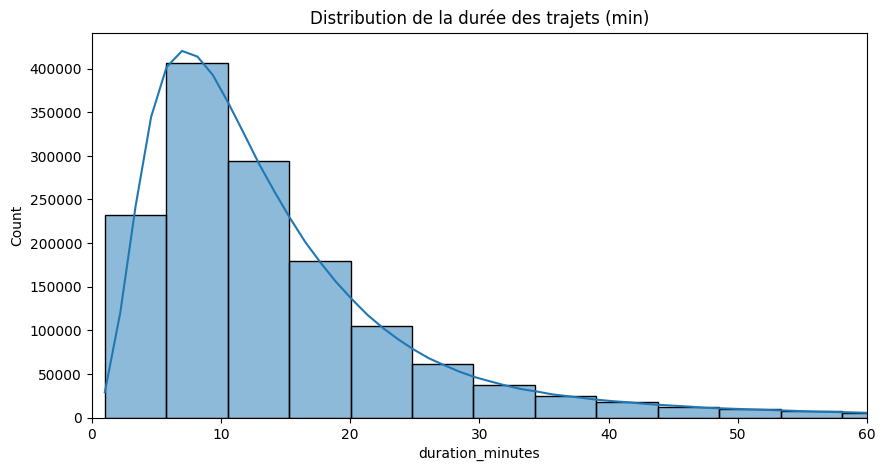

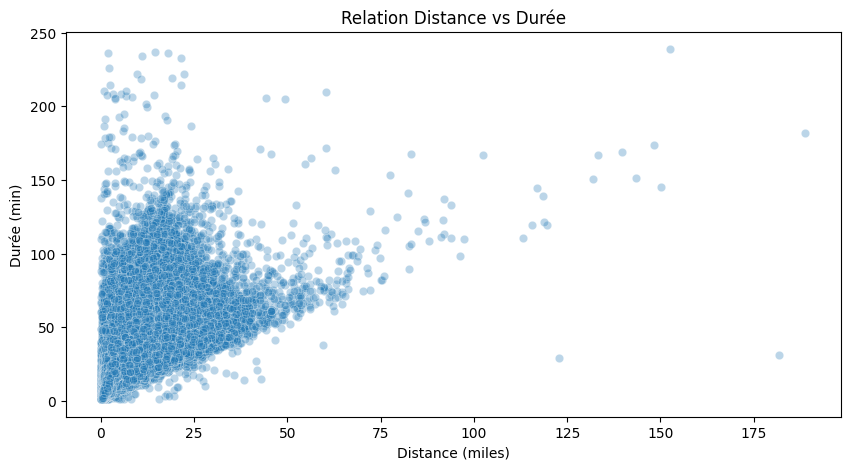

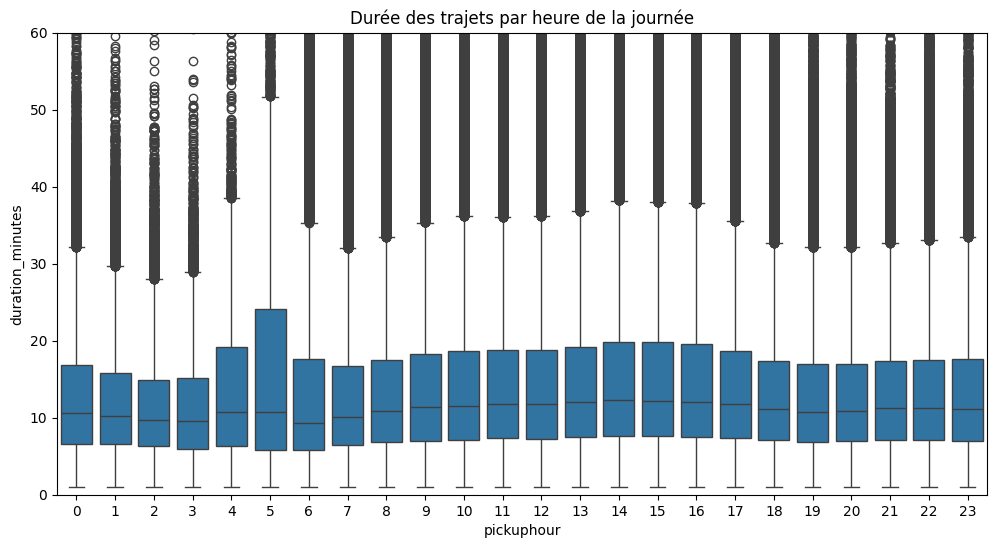

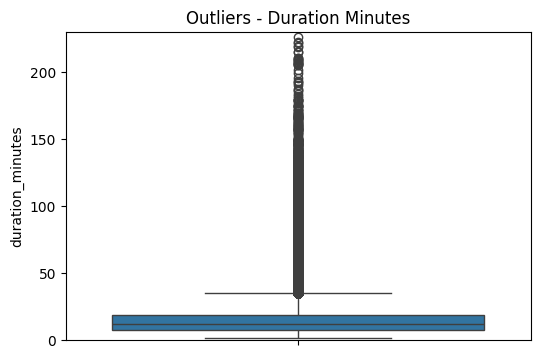

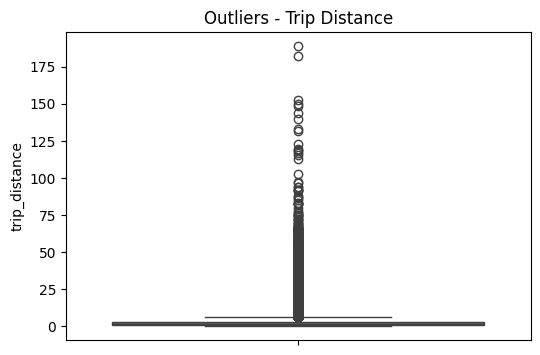

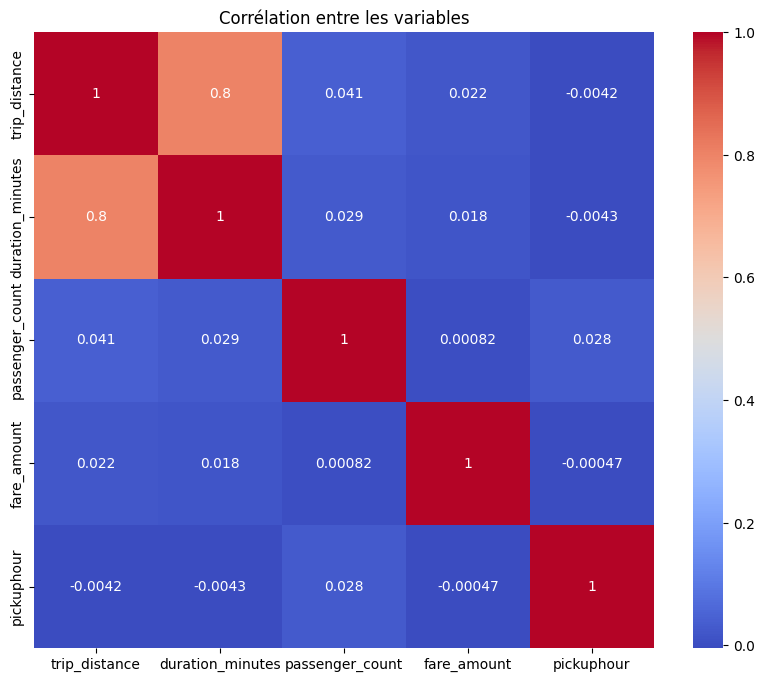

In [5]:
# 1. Échantillonnage pour la visualisation (ex: 5% des données ou max 100k lignes)
# C'est suffisant pour voir la distribution sans faire exploser la mémoire
df_sample = df_silver_clean.sample(fraction=0.5, seed=42).toPandas()
df_silver_clean.count()

print(f"Taille de l'échantillon pour visualisation : {len(df_sample)} lignes")

# 2. Distribution de la Target (Duration)
plt.figure(figsize=(10, 5))
sns.histplot(df_sample['duration_minutes'], bins=50, kde=True)
plt.title('Distribution de la durée des trajets (min)')
plt.xlim(0, 60) # Focus sur les trajets < 1h pour la lisibilité
plt.show()

# 3. Relation Distance vs Durée
plt.figure(figsize=(10, 5))
sns.scatterplot(x='trip_distance', y='duration_minutes', data=df_sample, alpha=0.3)
plt.title('Relation Distance vs Durée')
plt.xlabel('Distance (miles)')
plt.ylabel('Durée (min)')
plt.show()

# 4. Impact de l'heure de la journée
plt.figure(figsize=(12, 6))
sns.boxplot(x='pickuphour', y='duration_minutes', data=df_sample)
plt.title('Durée des trajets par heure de la journée')
plt.ylim(0, 60)
plt.show()

# 4b. Détection des outliers sur la target
plt.figure(figsize=(6,4))
sns.boxplot(y=df_sample["duration_minutes"])
plt.title("Outliers - Duration Minutes")
plt.ylim(0, 230)
plt.show()

# 4c. Détection des outliers sur la distance
plt.figure(figsize=(6,4))
sns.boxplot(y=df_sample["trip_distance"])
plt.title("Outliers - Trip Distance")
plt.show()


# 5. Matrice de corrélation
plt.figure(figsize=(10, 8))
# On ne garde que les colonnes numériques pertinentes
numeric_cols = ['trip_distance', 'duration_minutes', 'passenger_count', 'fare_amount', 'pickuphour']
sns.heatmap(df_sample[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Corrélation entre les variables')
plt.show()



In [6]:
features_num = [
    "trip_distance",
    "passenger_count",
    "pickuphour",
    "dayof_week",
    "month"
]

target = "duration_minutes"


In [7]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features_num,
    outputCol="features_raw"
)

df_feat = assembler.transform(df_silver_clean)

In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

scaler_model = scaler.fit(df_feat)
df_scaled = scaler_model.transform(df_feat)


In [9]:
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)

print("Train:", train_df.count())
print("Test:", test_df.count())


Train: 2245404


Test: 560283


In [10]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features",
    labelCol=target
)

lr_model = lr.fit(train_df)
lr_model.summary.r2

26/01/08 10:52:16 WARN Instrumentation: [f3e4422a] regParam is zero, which might cause numerical instability and overfitting.
26/01/08 10:52:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/01/08 10:52:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


0.6453692922972043

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lr_model.transform(test_df)

evaluator_rmse = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)

print("RMSE :", evaluator_rmse.evaluate(predictions))
print("R²   :", evaluator_r2.evaluate(predictions))


RMSE : 7.025258631782265


R²   : 0.6436358003578293


In [13]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    featuresCol="features",
    labelCol=target,
    maxIter=100,
    stepSize=0.1,
    seed=42
)

gbt_model = gbt.fit(train_df)

26/01/08 10:58:25 WARN MemoryStore: Not enough space to cache rdd_199_5 in memory! (computed 3.4 MiB so far)
26/01/08 10:58:25 WARN MemoryStore: Not enough space to cache rdd_199_0 in memory! (computed 8.2 MiB so far)
26/01/08 10:58:25 WARN MemoryStore: Not enough space to cache rdd_199_3 in memory! (computed 5.4 MiB so far)
26/01/08 10:58:25 WARN BlockManager: Persisting block rdd_199_3 to disk instead.
26/01/08 10:58:25 WARN BlockManager: Persisting block rdd_199_0 to disk instead.
26/01/08 10:58:25 WARN BlockManager: Persisting block rdd_199_5 to disk instead.
26/01/08 10:58:25 WARN MemoryStore: Not enough space to cache rdd_199_1 in memory! (computed 2.3 MiB so far)
26/01/08 10:58:25 WARN BlockManager: Persisting block rdd_199_1 to disk instead.
26/01/08 10:58:25 WARN MemoryStore: Not enough space to cache rdd_199_2 in memory! (computed 8.2 MiB so far)
26/01/08 10:58:25 WARN BlockManager: Persisting block rdd_199_2 to disk instead.
26/01/08 10:58:25 WARN MemoryStore: Not enough spa

In [14]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = gbt_model.transform(test_df)

evaluator_rmse = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)

print("RMSE :", evaluator_rmse.evaluate(predictions))
print("R²   :", evaluator_r2.evaluate(predictions))


RMSE : 5.780288523511059


R²   : 0.7587493637052324
